In [1]:
import time
import json

import onnxruntime
import onnx
import torch

import torch.nn as nn
from PIL import Image, ImageDraw
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor


device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [2]:
image_processor = RTDetrImageProcessor.from_pretrained("jadechoghari/RT-DETRv2")
image_processor.size = {'height': 480, 'width': 640}

In [3]:
rtdetrmodel = RTDetrForObjectDetection.from_pretrained("jadechoghari/RT-DETRv2")

In [ ]:
with open('labels.txt', 'w') as f:
    f.write(json.dumps(rtdetrmodel.config.id2label))

In [4]:
with open('labels.txt', 'r') as f:
    labels = json.loads(f.read())
    
print(labels)

{'0': 'person', '1': 'bicycle', '2': 'car', '3': 'motorbike', '4': 'aeroplane', '5': 'bus', '6': 'train', '7': 'truck', '8': 'boat', '9': 'traffic light', '10': 'fire hydrant', '11': 'stop sign', '12': 'parking meter', '13': 'bench', '14': 'bird', '15': 'cat', '16': 'dog', '17': 'horse', '18': 'sheep', '19': 'cow', '20': 'elephant', '21': 'bear', '22': 'zebra', '23': 'giraffe', '24': 'backpack', '25': 'umbrella', '26': 'handbag', '27': 'tie', '28': 'suitcase', '29': 'frisbee', '30': 'skis', '31': 'snowboard', '32': 'sports ball', '33': 'kite', '34': 'baseball bat', '35': 'baseball glove', '36': 'skateboard', '37': 'surfboard', '38': 'tennis racket', '39': 'bottle', '40': 'wine glass', '41': 'cup', '42': 'fork', '43': 'knife', '44': 'spoon', '45': 'bowl', '46': 'banana', '47': 'apple', '48': 'sandwich', '49': 'orange', '50': 'broccoli', '51': 'carrot', '52': 'hot dog', '53': 'pizza', '54': 'donut', '55': 'cake', '56': 'chair', '57': 'sofa', '58': 'pottedplant', '59': 'bed', '60': 'dinin

In [5]:
from dataclasses import dataclass

@dataclass
class DetrOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

In [ ]:
class Model(nn.Module):
    def __init__(self,) -> None:
        super().__init__()
        self.model = rtdetrmodel
        self.postprocessor = image_processor.post_process_object_detection

    def forward(self, images):
        outputs = self.model(images)
        outputs = self.postprocessor(outputs, target_sizes=torch.tensor([[480, 640]]), threshold=0.3)
        return outputs

In [6]:
data = torch.rand(1, 3, 480, 640)
rtdetrmodel.eval()

# model = Model()
# _ = model(data)
# model.eval()


torch.onnx.export(
    rtdetrmodel,
    # model,
    data,
    "model.onnx",
    export_params=True,
    opset_version=17,
    # opset_version=18,
    # opset_version=20,
    do_constant_folding=True,
    input_names=['images'],
    # output_names=['outputs'],
    # output_names=['logits', 'pred_boxes'],
    output_names=['scores', 'labels', 'boxes'],
)

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

c:\Users\User\anaconda3\envs\cv\Lib\site-packages\transformers\models\rt_detr\modeling_rt_detr_resnet.py:107: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
c:\Users\User\anaconda3\envs\cv\Lib\site-packages\transformers\models\rt_detr\modeling_rt_detr.py:1311: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  grid_w = torch.arange(int(width), dtype=dtype, device=device)
c:\Users\User\anaconda3\envs\cv\Lib\site-packages\transformers\models\rt_detr\modeling_rt_detr.py:1312: TracerWarning: Converting a tensor to a Python i

In [7]:
ort_session = onnxruntime.InferenceSession("model.onnx", providers=["CUDAExecutionProvider"])
# ort_session = onnxruntime.InferenceSession("model.onnx", providers=["CPUExecutionProvider"])
print(onnxruntime.get_device())

GPU


In [8]:
img = Image.open("000000039769.jpg")
print(img.size)
start = time.time()
input_tensor = image_processor(img, return_tensors="pt").to(device)
end = time.time()
print(f"image processor (pre): {end - start}")
print(input_tensor['pixel_values'].shape)

(640, 480)
image processor (pre): 0.024019956588745117
torch.Size([1, 3, 480, 640])


In [9]:
start = time.time()
ort_inputs = {'images': input_tensor["pixel_values"].cpu().numpy()}
ort_outs = ort_session.run(
    # output_names=['labels', 'boxes', 'scores'],
    output_names=None, 
    input_feed=ort_inputs
)
end = time.time()
print(f"model: {end - start}")

model: 0.21323728561401367


In [10]:
start = time.time()
detr_output = DetrOutput(logits = torch.from_numpy(ort_outs[0]).to("cuda"),
                         pred_boxes = torch.from_numpy(ort_outs[1]).to("cuda"))
results = image_processor.post_process_object_detection(detr_output, target_sizes=torch.tensor([img.size[::-1]]), threshold=0.3)
end = time.time()
print(f"image processor (post): {end - start}")

image processor (post): 0.056966304779052734


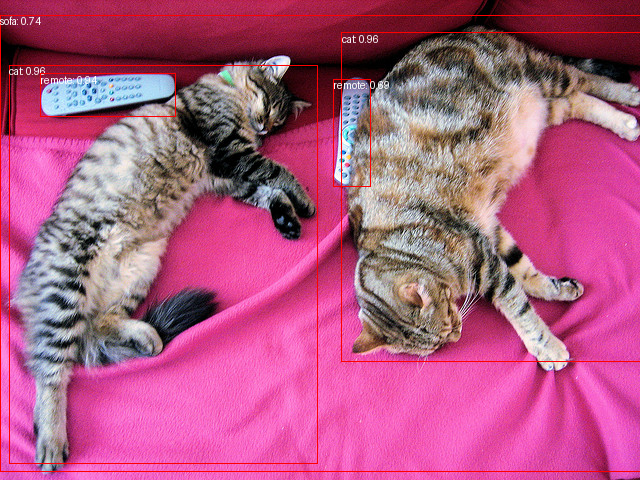

In [11]:
draw_img2 = img.copy()
draw = ImageDraw.Draw(draw_img2)

for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        if score > 0.5:
            draw.rectangle(box, fill=None, outline='red')
            draw.text((box[0], box[1]), f"{labels[str(label)]}: {score:.2f}")

display(draw_img2)

In [ ]:
draw_img2 = img.copy()
draw = ImageDraw.Draw(draw_img2)

for score, label, box in zip(ort_outs[0], ort_outs[1], ort_outs[2]):
    box = [round(i, 2) for i in box]
    if score > 0.5:
        draw.rectangle(box, fill=None, outline='red')
        draw.text((box[0], box[1]), f"{rtdetrmodel.config.id2label[label]}: {score:.2f}")

display(draw_img2)